## Diffusion Models: brief introduction

Diffusion models are a relatively recent addition to a group of algorithms known as `generative models`. The diffusion's generation process begins with random noise, but this is gradually refined over a number of steps until an output image emerges. At each step, the model estimates how we could go from the current input to a completely denoised version.

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Training process of the diffusion model is conducted repeatedly and consists of following steps:

  1. Load images from the training data
  2. Curruption process (add noise)
  3. Feed the noisy versions of the inputs into the model
  4. Evaluate how well the model does at denoising these inputs
  5. Use this information to update the model weights

To generate new images with a trained model, we begin with a completely random input and repeatedly feed it through the model, updating it each time by a small amount based on the model prediction.  

### Setup and Imports

In [10]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Load data

To speed up the learning process, we are going to use a small dataset - MNIST.

In [2]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 186411417.39it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105518897.06it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52850352.26it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4482477.36it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



### The corruption process

We need to add noise to input images, then feed the noisy images to the model. The DDPM paper describes a corruption process that gradually adds a small amount of noise. Let us implement the simplified version of this approach:

In [6]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1)
  return x*(1-amount) + noise*amount

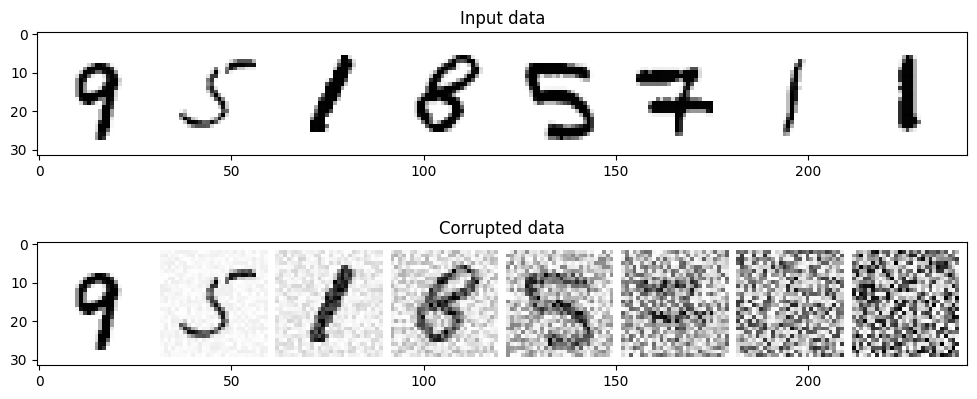

In [7]:
# Plotting the input data
x, y = next(iter(train_dataloader))
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## The Model

We need a model that takes noisy images as an input and outputs a prediction of the same shape. We can use UNet for this purpose.

In [8]:
class UNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

## Training the network

Given a corrupted input noisy_x the model should output its best guess for what the original x looks like. Mean squared error will be used as the loss function.

  2%|▎         | 1/40 [00:11<07:10, 11.03s/it]

Finished epoch 0. Average loss for this epoch: 0.026476


  5%|▌         | 2/40 [00:21<06:46, 10.70s/it]

Finished epoch 1. Average loss for this epoch: 0.020563


  8%|▊         | 3/40 [00:32<06:33, 10.63s/it]

Finished epoch 2. Average loss for this epoch: 0.018987


 10%|█         | 4/40 [00:42<06:21, 10.58s/it]

Finished epoch 3. Average loss for this epoch: 0.018123


 12%|█▎        | 5/40 [00:52<06:03, 10.39s/it]

Finished epoch 4. Average loss for this epoch: 0.017498


 15%|█▌        | 6/40 [01:03<05:54, 10.43s/it]

Finished epoch 5. Average loss for this epoch: 0.016968


 18%|█▊        | 7/40 [01:13<05:45, 10.47s/it]

Finished epoch 6. Average loss for this epoch: 0.016632


 20%|██        | 8/40 [01:24<05:35, 10.47s/it]

Finished epoch 7. Average loss for this epoch: 0.016543


 22%|██▎       | 9/40 [01:34<05:25, 10.49s/it]

Finished epoch 8. Average loss for this epoch: 0.016293


 25%|██▌       | 10/40 [01:45<05:14, 10.48s/it]

Finished epoch 9. Average loss for this epoch: 0.016244


 28%|██▊       | 11/40 [01:55<05:04, 10.49s/it]

Finished epoch 10. Average loss for this epoch: 0.015932


 30%|███       | 12/40 [02:06<04:54, 10.51s/it]

Finished epoch 11. Average loss for this epoch: 0.015789


 32%|███▎      | 13/40 [02:16<04:41, 10.41s/it]

Finished epoch 12. Average loss for this epoch: 0.015640


 35%|███▌      | 14/40 [02:26<04:30, 10.42s/it]

Finished epoch 13. Average loss for this epoch: 0.015594


 38%|███▊      | 15/40 [02:37<04:21, 10.46s/it]

Finished epoch 14. Average loss for this epoch: 0.015394


 40%|████      | 16/40 [02:47<04:11, 10.50s/it]

Finished epoch 15. Average loss for this epoch: 0.015176


 42%|████▎     | 17/40 [02:58<04:01, 10.50s/it]

Finished epoch 16. Average loss for this epoch: 0.014742


 45%|████▌     | 18/40 [03:09<03:52, 10.56s/it]

Finished epoch 17. Average loss for this epoch: 0.014389


 48%|████▊     | 19/40 [03:19<03:41, 10.55s/it]

Finished epoch 18. Average loss for this epoch: 0.014014


 50%|█████     | 20/40 [03:30<03:31, 10.55s/it]

Finished epoch 19. Average loss for this epoch: 0.013722


 52%|█████▎    | 21/40 [03:40<03:19, 10.48s/it]

Finished epoch 20. Average loss for this epoch: 0.013623


 55%|█████▌    | 22/40 [03:50<03:07, 10.43s/it]

Finished epoch 21. Average loss for this epoch: 0.013359


 57%|█████▊    | 23/40 [04:01<02:57, 10.47s/it]

Finished epoch 22. Average loss for this epoch: 0.013374


 60%|██████    | 24/40 [04:12<02:48, 10.50s/it]

Finished epoch 23. Average loss for this epoch: 0.013025


 62%|██████▎   | 25/40 [04:22<02:37, 10.53s/it]

Finished epoch 24. Average loss for this epoch: 0.012989


 65%|██████▌   | 26/40 [04:33<02:27, 10.52s/it]

Finished epoch 25. Average loss for this epoch: 0.013044


 68%|██████▊   | 27/40 [04:43<02:17, 10.55s/it]

Finished epoch 26. Average loss for this epoch: 0.012780


 70%|███████   | 28/40 [04:54<02:06, 10.55s/it]

Finished epoch 27. Average loss for this epoch: 0.012801


 72%|███████▎  | 29/40 [05:04<01:55, 10.52s/it]

Finished epoch 28. Average loss for this epoch: 0.012703


 75%|███████▌  | 30/40 [05:15<01:44, 10.45s/it]

Finished epoch 29. Average loss for this epoch: 0.012601


 78%|███████▊  | 31/40 [05:25<01:34, 10.48s/it]

Finished epoch 30. Average loss for this epoch: 0.012607


 80%|████████  | 32/40 [05:36<01:24, 10.51s/it]

Finished epoch 31. Average loss for this epoch: 0.012423


 82%|████████▎ | 33/40 [05:46<01:13, 10.53s/it]

Finished epoch 32. Average loss for this epoch: 0.012329


 85%|████████▌ | 34/40 [05:57<01:03, 10.54s/it]

Finished epoch 33. Average loss for this epoch: 0.012323


 88%|████████▊ | 35/40 [06:07<00:52, 10.55s/it]

Finished epoch 34. Average loss for this epoch: 0.012355


 90%|█████████ | 36/40 [06:18<00:42, 10.56s/it]

Finished epoch 35. Average loss for this epoch: 0.012305


 92%|█████████▎| 37/40 [06:29<00:31, 10.55s/it]

Finished epoch 36. Average loss for this epoch: 0.012305


 95%|█████████▌| 38/40 [06:39<00:20, 10.46s/it]

Finished epoch 37. Average loss for this epoch: 0.012088


 98%|█████████▊| 39/40 [06:49<00:10, 10.46s/it]

Finished epoch 38. Average loss for this epoch: 0.012189


100%|██████████| 40/40 [07:00<00:00, 10.51s/it]

Finished epoch 39. Average loss for this epoch: 0.012181


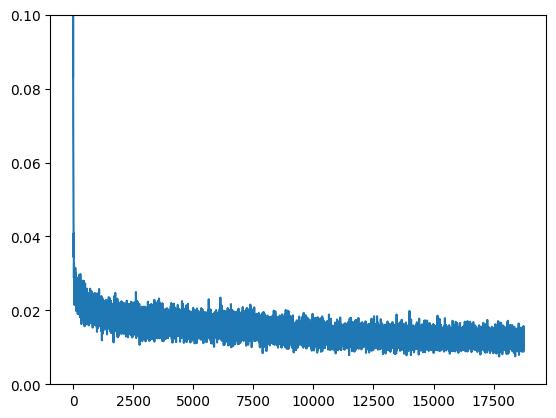

In [52]:
# Dataloader
batch_size = 128
n_epochs = 40
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create the network
net = UNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in tqdm(range(n_epochs)):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

### Sampling

Strarting from random noise, the model makes a prediction, but then we onlu take a tiny step towards that prediction. The hope is that this new prediction is slightly better than the first one and we can take another small step with this new, better prediction.

Let's illustrate this process with the small number of steps:

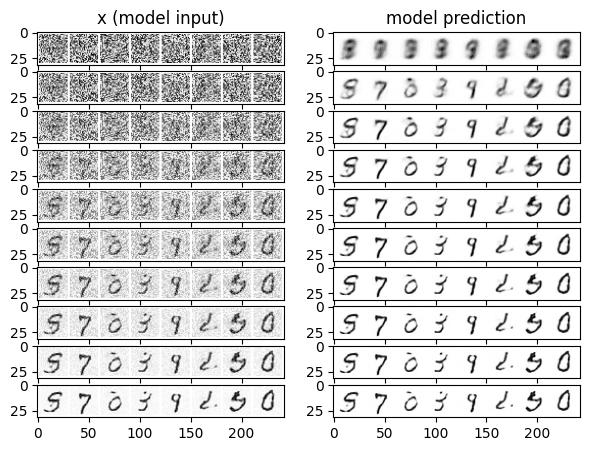

In [43]:
# Break the process into n steps and move 1/n'th of the way there each time:
n_steps = 10
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(7, 5), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

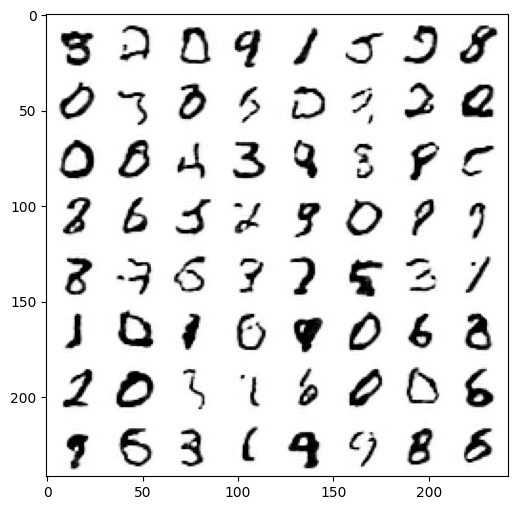

In [68]:
# Generate more results
n_steps = 500
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

Not great, not terrible, but still the result. This was rather simplified realisation, but it illustrates the main idea of the method proposed in the paper.